Best practices:

* declare tools in system prompt (managable with the amount we have)

# Capabilities and Organization

## Capabilities

**general / coordinator**

* state awareness
* reading overall high-level message flow

**input data processing**

* bathymetry and mesh
* initial conditions
* (optional/later) boundary conditions

**setup file and parameter management**

* knowledge of and modification capabilities for setup files
* bookkeeping of setup files

**evaluation**
* plotting
* evaluation of plots

## Organization

* central file with paths, client etc that can be accessed by all modules
* 

# initialize AI

#### Connect to model

In [2]:
from dotenv import load_dotenv
from IPython.display import display, HTML, Image
import os
from openai import AzureOpenAI
import json

load_dotenv()

API_KEY = os.getenv("AZURE_API_KEY")
DEPLOYMENT_ENDPOINT = os.getenv("AZURE_DEPLOYMENT_ENDPOINT")
DEPLOYMENT_NAME = os.getenv("GPT4o_DEPLOYMENT_NAME")
API_VERSION = "2023-03-15-preview" # API VERSION != MODEL VERSION!!!!! Get from deployment targt in Azure AI Studio

client = AzureOpenAI(
  azure_endpoint = DEPLOYMENT_ENDPOINT,
  api_key=API_KEY,  
  api_version=API_VERSION

)

print(f"Azure AI initialized with\nEndpoint: {DEPLOYMENT_ENDPOINT}\nName: {DEPLOYMENT_NAME} and\API version: {API_VERSION}")

Azure AI initialized with
Endpoint: https://openai-test-v3.openai.azure.com/
Name: gpt-4o and\API version: 2023-03-15-preview


#### core function to handle interaction with LLM and function calling

In [29]:
from func_helpers import function_descriptions, available_functions
import json

def call_azure_ai(usr_message, tools):
    # append user message to message list
    messages.append({"role": "user", "content": usr_message})
    
    # Step 1: generate response
    response = client.chat.completions.create(
        model=DEPLOYMENT_NAME,
        messages=messages,
        functions=tools,
        function_call="auto",
    )

    response_message = response.choices[0].message
    #print(response_message) # JUST FOR DEBUGGING

    # Step 2: check if GPT wanted to call a function
    if response_message.function_call:
        # Step 3: call the function
        function_name = response_message.function_call.name
        # verify function exists
        if function_name not in available_functions:
            return "Function " + function_name + " does not exist"
        function_to_call = available_functions[function_name]
        # verify function has correct number of arguments
        function_args = json.loads(response_message.function_call.arguments)
        #messages.append({"role": response_message.role, "content": f"Calling function {function_name} with arguments {function_args}"})
        try:
            function_response = function_to_call(**function_args) # non-pydantic version
            print(function_response) # JUST FOR DEBUGGING
            messages.append({
                "role": "function", 
                "name": function_name,
                "content": str(function_response)})
            # synthesize response with function output 
            response = client.chat.completions.create(
                model=DEPLOYMENT_NAME,
                messages=messages,
            )
            response_message = response.choices[0].message
            print(response) # JUST FOR DEBUGGING
            messages.append({"role": response_message.role, "content": response_message.content})
        # catch other exceptions when calling function
        except Exception as e:
            print("exception in function call")
            return str(e)
    # in case no function was called
    else:
        messages.append({"role": response_message.role, "content": response_message.content})



# just a helper for nice display in notebook
from IPython.display import display, Markdown

def display_message_as_markdown(response_message):
    # Extract the content from the response_message
    content = response_message["content"]

    # Display the content as Markdown
    display(Markdown(content))


#### System prompt


In [4]:
# system prompt

sys_prompt = """You are an engineering assistant that helps to build, run 2D numerical fluid simulations with DHIs MIKE21FM software and evaluate them. 
For this you have access to a set of functions that let you
1. get an overview of available files in different subfolders (e.g. setup) with tool "list_model_files"
2. open setup files and return parameters with tool "get_pfs_parameters", 
3. create mesh and bathymetry with tool "create_mesh_bathymetry", 
4. create initial conditions with tool "create_surface_elevation",
5. plot mesh, bathymetry or initial conditions with tool "plot_mesh_bathy",
6. run simulations with tool "simulate",
7. plot results e.g. if user asks to please plot with tool "plot_results",
8. evaluate plots with "evaluate_results"

In case a user needs guidance on building a numerical setup, you can walk him step-by-step through the setup process by either assuming or asking the user for 
parameters you need for the function calls. Always let the user know if you are assuming some parameter and justify your assumption.
"""


#### Initialize / Clear chat message history

`messages`: List that will be initialized only after the system prompt and afterwards continue to append


In [5]:
def initialize_chat():
    "function to initialize chat with system prompt, can also be used to clear everything else"
    global messages
    messages = [{"role": "system", "content": sys_prompt}]

In [6]:
initialize_chat()
messages

[{'role': 'system',
  'content': 'You are an engineering assistant that helps to build, run 2D numerical fluid simulations with DHIs MIKE21FM software and evaluate them. \nFor this you have access to a set of functions that let you\n1. get an overview of available files in different subfolders (e.g. setup) with tool "list_model_files"\n2. open setup files and return parameters with tool "get_pfs_parameters", \n3. create mesh and bathymetry with tool "create_mesh_bathymetry", \n4. create initial conditions with tool "create_surface_elevation",\n5. plot mesh, bathymetry or initial conditions with tool "plot_mesh_bathy",\n6. run simulations with tool "simulate",\n7. plot results e.g. if user asks to please plot with tool "plot_results",\n8. evaluate plots with "evaluate_results"\n\nIn case a user needs guidance on building a numerical setup, you can walk him step-by-step through the setup process by either assuming or asking the user for \nparameters you need for the function calls. Alway

-----

# Workflow

Workflows from listing files, creating new ones (bathymetry and initial conditions) as well as running simulations and evaluating results are displayed below.<br>
In this Notebook functions are called in two ways 

1. first the function is called manually
2. the function is called implicitly via a natural language user interaction


`initialize_chat()` can be called at any time to reset the message history to the system prompt.


**1. manual function call** 

In [6]:
# list all in  /teamspace/studios/this_studio/mk-assistant/sim_data/domain
from func_helpers import list_model_files
list_model_files()

"{'setup': ['sim_.m21fm'], 'boundaries': [], 'initial': ['surface_elevation_100x30_dx10wave5x200left.dfs2'], 'domain': ['mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2', 'mesh_bathy_100x30_dx10_reference-20_slope0.8.dfs2'], 'result': ['sim_.dfsu', 'sim_0.dfsu', 'sim_1.dfsu'], 'figure': ['sim_sim_0_ts0.png', 'sim_sim_0_ts2.png', 'sim_sim_0_ts4.png', 'sim_sim_0_ts6.png', 'sim_sim_1_ts0.png', 'sim_sim_1_ts2.png', 'sim_sim_1_ts4.png', 'sim_sim_1_ts6.png']}"

**2. AI function call**

In [7]:
initialize_chat()

In [8]:
usr_message = "list available setup files"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


{'setup': ['sim_.m21fm']}
ChatCompletion(id='chatcmpl-9YtWsUGeOqFgbfLURZAp3XfxO9z2n', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='I found the following setup file available:\n\n- `sim_.m21fm`\n\nWhat would you like to do next? You could perhaps open the setup file to check its parameters, create new setup elements, run a simulation, or evaluate results. Please let me know how you would like to proceed!', role='assistant', function_call=None, tool_calls=None))], created=1718103634, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=60, prompt_tokens=231, total_tokens=291))


I found the following setup file available:

- `sim_.m21fm`

What would you like to do next? You could perhaps open the setup file to check its parameters, create new setup elements, run a simulation, or evaluate results. Please let me know how you would like to proceed!

## mesh and bathymetry

### create

* leverages `func_helpers.py` and included `create_mesh_bathymetry`


**1. manual function call**

In [3]:
from func_helpers import create_mesh_bathymetry

nx = 100
ny = 30
dx = 10
dy = 10
reference_depth = -20 # from where to start the slope
slope_degrees = 0.2 # from left to right. Negative = decrease depth from left to right
create_mesh_bathymetry(nx, ny, dx, dy, reference_depth, slope_degrees)

'Bathymetry dataset saved to: /teamspace/studios/this_studio/mk-assistant/sim_data/domain/mesh_bathy_100x30_dx10_reference-20_slope0.2.dfs2'

**2. AI function call**

In [9]:
initialize_chat()

In [10]:
usr_message = "let's create a new mesh and bathymetry. I would like a reference depth of -20 m, and a positive .7degree slope, 100 elements in x and 30 in y-direction with 10 m grid cell size in both directions"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


Bathymetry dataset saved to: /teamspace/studios/this_studio/mk-assistant/sim_data/domain/mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2
ChatCompletion(id='chatcmpl-9YtXhVb1LMDSWDMhS0EpY6VsMtmcG', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The mesh and bathymetry have been created with the specified parameters:\n- Reference depth of -20 meters\n- Positive 0.7-degree slope\n- 100 elements in the x-direction\n- 30 elements in the y-direction\n- 10-meter grid cell size in both directions\n\nThe bathymetry dataset has been saved to: `/teamspace/studios/this_studio/mk-assistant/sim_data/domain/mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2`.\n\nWhat would you like to do next? You can create initial conditions, set up boundary conditions, or perform other tasks related to your simulation.', role='assistant', function_call=None, tool_calls=None))], created=1718103685, model='gpt-4o-2024-05-13', object='chat.completion', system_fin

The mesh and bathymetry have been created with the specified parameters:
- Reference depth of -20 meters
- Positive 0.7-degree slope
- 100 elements in the x-direction
- 30 elements in the y-direction
- 10-meter grid cell size in both directions

The bathymetry dataset has been saved to: `/teamspace/studios/this_studio/mk-assistant/sim_data/domain/mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2`.

What would you like to do next? You can create initial conditions, set up boundary conditions, or perform other tasks related to your simulation.

### plot mesh and bathymetry


**1. manual function call**

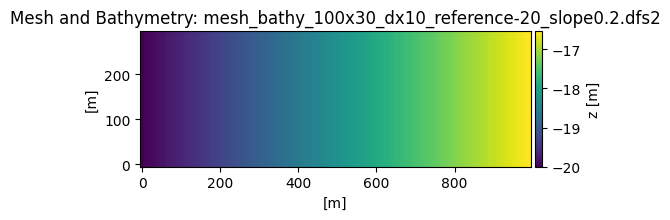

In [4]:
from func_helpers import plot_mesh_bathy
fn_mesh = "mesh_bathy_100x30_dx10_reference-20_slope0.2.dfs2"
plot_mesh_bathy(fn_mesh, plot_type='mesh_bathy');

**2. AI function call**

NOTE: for streamlit or other apps, how to plot the figure might differ.

Figure(600x175.758)
ChatCompletion(id='chatcmpl-9YtXwbFCM8pvAffLAlTIL9u709C0r', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Here is the plot of the mesh and bathymetry you just created. \n\nPlease let me know if you need any further details or would like to proceed with the next steps, such as setting up initial conditions or boundary conditions.', role='assistant', function_call=None, tool_calls=None))], created=1718103700, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=46, prompt_tokens=481, total_tokens=527))


Here is the plot of the mesh and bathymetry you just created. 

Please let me know if you need any further details or would like to proceed with the next steps, such as setting up initial conditions or boundary conditions.

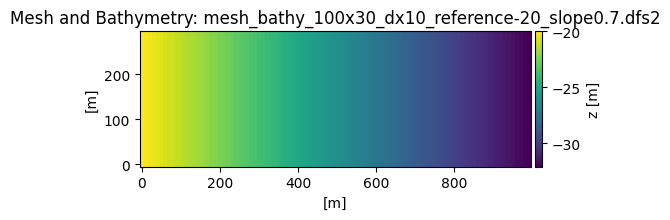

In [11]:
usr_message = "can you plot this?"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


## initial condition

### create new 

* leverages `func_helpers.py` and included `create_surface_elevation`

**1. manual function call**

In [127]:
from func_helpers import create_surface_elevation
wave_height = 5.0
wave_width = 200.0
wave_position = 'left'
create_surface_elevation(nx, ny, dx, dy, wave_height, wave_width, wave_position)

'Initial surface elevation dataset saved to: /teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5.0x200.0left.dfs2'

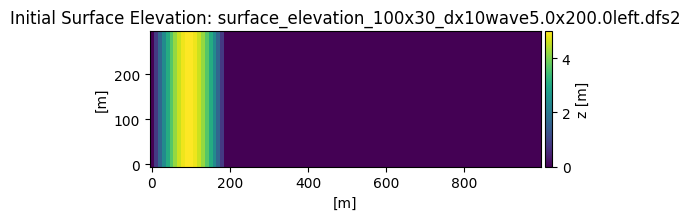

In [128]:
#fn_mesh = "/teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5.0x200.0left.dfs2"
fn_mesh = "surface_elevation_100x30_dx10wave5.0x200.0left.dfs2"
plot_mesh_bathy(fn_mesh, plot_type='initial');

**2. AI function call**

In [12]:
initialize_chat()

In [13]:
usr_message = "create a new surface elevation with a wave height of 5m, a wave width of 200m and the wave position on the left side. Nx should be 100, Ny 30, dx and dy 10m"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


Initial surface elevation dataset saved to: /teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5x200left.dfs2
ChatCompletion(id='chatcmpl-9YtYEHjP9glMvAHSxLSHH7ftpoxvM', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='I have created the initial surface elevation dataset with the specified parameters. The file is saved as `/teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5x200left.dfs2`. This dataset includes a wave height of 5m, wave width of 200m, and the wave positioned on the left side, with grid dimensions Nx=100, Ny=30, and cell size dx=dy=10m.\n\nWould you like to proceed with a specific next step, such as creating a mesh or specifying other initial or boundary conditions?', role='assistant', function_call=None, tool_calls=None))], created=1718103718, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', us

I have created the initial surface elevation dataset with the specified parameters. The file is saved as `/teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5x200left.dfs2`. This dataset includes a wave height of 5m, wave width of 200m, and the wave positioned on the left side, with grid dimensions Nx=100, Ny=30, and cell size dx=dy=10m.

Would you like to proceed with a specific next step, such as creating a mesh or specifying other initial or boundary conditions?

### Plotting initial conditions

**1. manual function call**

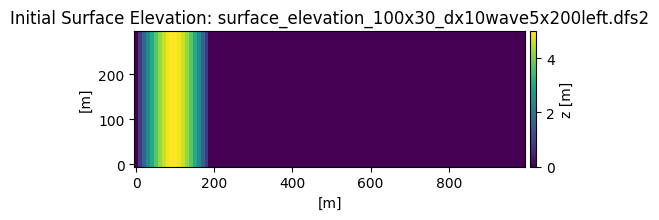

In [133]:
from func_helpers import plot_mesh_bathy
fn_mesh = "surface_elevation_100x30_dx10wave5x200left.dfs2"
plot_mesh_bathy(fn_mesh, plot_type='initial');

**2. AI function call**

NOTE: for streamlit or other apps, how to plot the figure might differ.

Figure(600x175.758)
ChatCompletion(id='chatcmpl-9YtYSJw2xaYbJMaEuZbbHamxpW5U0', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='I have plotted the surface elevation with your specified parameters. Please review the plot to ensure it meets your requirements.\n\nWould you like to proceed with any other tasks, such as creating a mesh, defining boundary conditions, or running a simulation?', role='assistant', function_call=None, tool_calls=None))], created=1718103732, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=47, prompt_tokens=459, total_tokens=506))


I have plotted the surface elevation with your specified parameters. Please review the plot to ensure it meets your requirements.

Would you like to proceed with any other tasks, such as creating a mesh, defining boundary conditions, or running a simulation?

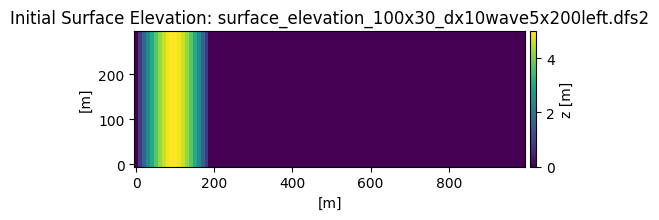

In [14]:
usr_message = "plot this"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


## get parameters from pfs template
* <mark>Ask JEM how to create a very simplistic m21fm</mark>
* leverages `func_helpers.py` and included `get_pfs_parameters`. This is basically a boiled down version of mikeio pfs



**1. manual function call**

In [7]:
from func_helpers import get_pfs_parameters

# load from .m21fm template
temp_pfs = "sim_.m21fm" # template of pfs file
get_pfs_parameters(temp_pfs)

{'start_time': '2023-12-01 05:05:00',
 'time_step_interval': 10.0,
 'number_of_time_steps': 104,
 'domain_file': '|..\\bathy\\bathy_128x128_dx100.0_reference-15_slope0.0.dfs2|',
 'initial_conditions_file': '|..\\initial\\surface_elevation_128x128_dx100.0_wave2x400_left.dfs2|',
 'initial_surface_elevation': 0.0,
 'boundary_conditions_file': '||',
 'manning_number': 32.0}

**2. AI function call**

In [ ]:
initialize_chat()

In [15]:
usr_message = "show parameters of sim_.m21fm"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


{'start_time': '2023-12-01 05:05:00', 'time_step_interval': 10.0, 'number_of_time_steps': 104, 'domain_file': '|..\\domain\\mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2|', 'initial_conditions_file': '|..\\initial\\surface_elevation_100x30_dx10wave5x200left.dfs2|', 'initial_surface_elevation': 0.0, 'boundary_conditions_file': '|.\\Helgoland_Binnenhafen_H.dfs0|', 'manning_number': 32.0}
ChatCompletion(id='chatcmpl-9YtYzALDJn1mQx6TAHsqFJgIbsoxj', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Here are the parameters for the simulation file `sim_.m21fm`:\n\n- **Start Time**: 2023-12-01 05:05:00\n- **Time Step Interval**: 10.0 seconds\n- **Number of Time Steps**: 104\n- **Domain File**: `..\\domain\\mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2`\n- **Initial Conditions File**: `..\\initial\\surface_elevation_100x30_dx10wave5x200left.dfs2`\n- **Initial Surface Elevation**: 0.0\n- **Boundary Conditions File**: `.\\Helgoland_Binnen

Here are the parameters for the simulation file `sim_.m21fm`:

- **Start Time**: 2023-12-01 05:05:00
- **Time Step Interval**: 10.0 seconds
- **Number of Time Steps**: 104
- **Domain File**: `..\domain\mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2`
- **Initial Conditions File**: `..\initial\surface_elevation_100x30_dx10wave5x200left.dfs2`
- **Initial Surface Elevation**: 0.0
- **Boundary Conditions File**: `.\Helgoland_Binnenhafen_H.dfs0`
- **Manning Number**: 32.0

Would you like to adjust any of these parameters, proceed with running a simulation, or perform other tasks?

## temp setup

* create temp m21fm from template (could also just be a file with changable params that are later written to m21fm)
* automatically track and update params from conversation (add writing in each function?)
* before simulation execution, in the simulate function(?) there should be a "commit" of the last m21fm to the setup folder  

In [2]:
default_params = {
    "start_time": "",
    "time_step_interval": 0,
    "number_of_time_steps": 0,
    "domain_file": "",
    "initial_conditions_file": "",
    "manning_number": 0
}

In [3]:
default_params

{'start_time': '',
 'time_step_interval': 0,
 'number_of_time_steps': 0,
 'domain_file': '',
 'initial_conditions_file': '',
 'manning_number': 0}

In [ ]:
from parameter_state import state_llm

response = state_llm("i have changed manning number to 20")
response

In [ ]:

llm_response = get_llm_response(conversation)
for key, value in llm_response.items():
    if key in st.session_state.params:
        st.session_state.params[key] = value

## alter m21fm parameters

* use correct domain_file
* use correct initial_conditions_file
* use correct boundary_conditions_file (should automatically checked with other boundary settings, is the file actually used?)
<mark> Create new pfs from scratch with boundaries properly labeled (left, right) which can be seen in pfs['FemEngineHD']['DOMAIN']['BOUNDARY_NAMES'] a) open boundary b) sinusodial wave
* alter other parameters
* <mark> label outputs clearer - always only 2d dfsu named like the simulation file - and write to results folder </mark>

In [8]:
from mikeio import Pfs
pfs = Pfs(temp_pfs)

modify in pfs object

In [37]:
# get correct domain and initial conditions files in
pfs['FemEngineHD']['DOMAIN']['file_name'] = "/teamspace/studios/this_studio/mk-assistant/sim_data/domain/mesh_bathy_100x30_dx10_reference-20_slope0.8.dfs2"
pfs['FemEngineHD']['HYDRODYNAMIC_MODULE']['INITIAL_CONDITIONS']['file_name_2D'] = "/teamspace/studios/this_studio/mk-assistant/sim_data/initial/surface_elevation_100x30_dx10wave5.0x200.0left.dfs2"

# write pfs file
pfs.write("/teamspace/studios/this_studio/mk-assistant/sim_data/setup/sim_0.m21fm")


# set manning number
pfs['FemEngineHD']['HYDRODYNAMIC_MODULE']['BED_RESISTANCE']['MANNING_NUMBER']['constant_value'] = 90
pfs.write("/teamspace/studios/this_studio/mk-assistant/sim_data/setup/sim_1.m21fm")


## simulate

* CPU/GPU and number of cores will be determined.
* number of subdomains and threads will be determined from hardware automatically

In [11]:
# in case license / authentication is required by MIKE
#import os
#password = os.environ.get('MIKE_LICENSE_PASSWORD')
#!/teamspace/studios/this_studio/MIKE/2024/bin/licconfig set --type=internet --iuser=clcr@dhigroup.com --ipassword="$password"

command: set
load configuration: /teamspace/studios/this_studio/.config/DHI/license/NetLmLcwConfig.xml
save configuration: /teamspace/studios/this_studio/.config/DHI/license/NetLmLcwConfig.xml
type: internet
iuser: clcr@dhigroup.com
ipassword: ***


**1. manual function call**

In [1]:
from func_helpers import simulate
simfile_name = "sim_.m21fm"

simulate(simfile_name)

CUDA is not available
Running simulation on CPU
Number of CPUs/cores available: 4
STDOUT:  Initializing
 DFS open error on /teamspace/studios/this_studio/simple_mk-assistant/sim_data/d
 omain/mesh_bathy_100x30_dx10_reference-20_slope0.7.dfs2

=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   RANK 1 PID 10981 RUNNING AT ip-10-192-12-200
=   KILLED BY SIGNAL: 9 (Killed)

=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   RANK 2 PID 10982 RUNNING AT ip-10-192-12-200
=   KILLED BY SIGNAL: 9 (Killed)

STDERR: 
Execution time: 4.31 seconds


"Error copying simulation results: [Errno 2] No such file or directory: '/teamspace/studios/this_studio/simple_mk-assistant/sim_data/setup/sim_.m21fm - Result Files/area.dfsu'. Likely simulation error"

**2. AI function call**

In [54]:
initialize_chat()

In [11]:
usr_message = "please run sim_.m21fm"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])


CUDA is not available
Running simulation on CPU
Number of CPUs/cores available: 4
STDOUT:  Initializing
 Time step: 0
 Time step: 13

STDERR: 
Execution time: 9.33 seconds
Simulation ran successfully, results copied to /teamspace/studios/this_studio/mk-assistant/sim_data/results/sim_.dfsu
ChatCompletion(id='chatcmpl-9YuaManN8M3p9e4xASxqfNRVPrTaH', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The simulation has been run successfully. You can find the results in the directory `/teamspace/studios/this_studio/mk-assistant/sim_data/results/sim_.dfsu`. Would you like to evaluate these results or perform any other tasks?', role='assistant', function_call=None, tool_calls=None))], created=1718107694, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=51, prompt_tokens=255, total_tokens=306))


The simulation has been run successfully. You can find the results in the directory `/teamspace/studios/this_studio/mk-assistant/sim_data/results/sim_.dfsu`. Would you like to evaluate these results or perform any other tasks?

## plot


**1. manual function call**

'Plots saved to /teamspace/studios/this_studio/mk-assistant/sim_data/figures as sim_slope1p0.png'

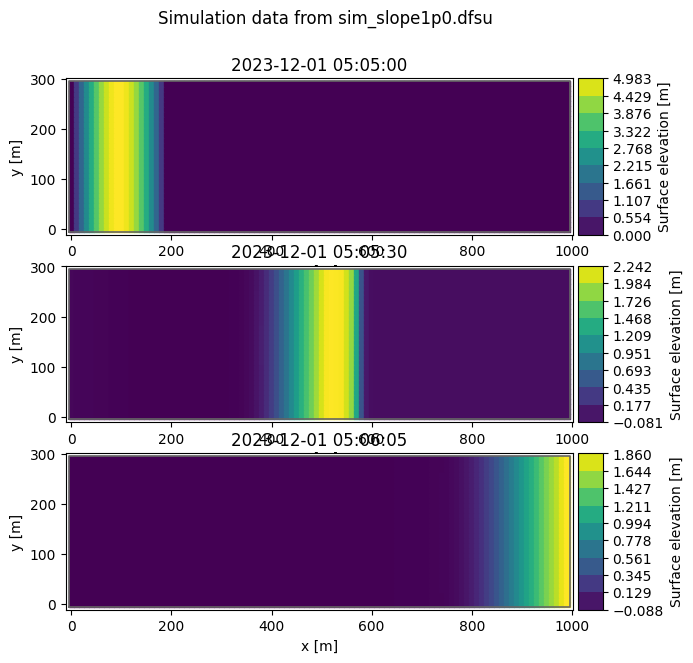

In [2]:
import func_helpers
#simulation = "sim_.dfsu"

func_helpers.plot_results(simulation, n_times=3)       

**2. AI function call**

In [15]:
initialize_chat()

Plots saved to /teamspace/studios/this_studio/mk-assistant/sim_data/figures as sim_.png.png
ChatCompletion(id='chatcmpl-9Yv6AOFeuVJD5QcejRX08YTi2W2Yi', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='I have plotted three timesteps from the results of `sim_.dfsu`. The plots are saved in the directory:\n\n```\n/teamspace/studios/this_studio/mk-assistant/sim_data/figures/sim_.png.png\n```\n\nIf you need any further assistance or help in evaluating these results, feel free to ask!', role='assistant', function_call=None, tool_calls=None))], created=1718109666, model='gpt-4o-2024-05-13', object='chat.completion', system_fingerprint='fp_5f4bad809a', usage=CompletionUsage(completion_tokens=71, prompt_tokens=285, total_tokens=356))


I have plotted three timesteps from the results of `sim_.dfsu`. The plots are saved in the directory:

```
/teamspace/studios/this_studio/mk-assistant/sim_data/figures/sim_.png.png
```

If you need any further assistance or help in evaluating these results, feel free to ask!

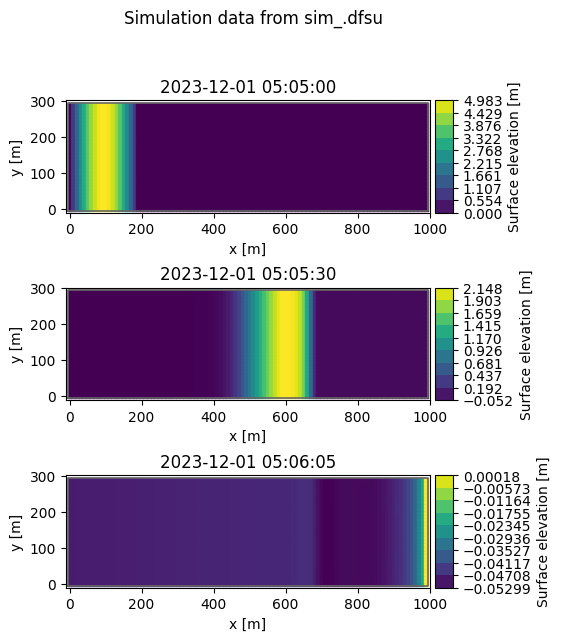

In [7]:
usr_message = "please plot three timesteps from results of sim_.dfsu"
call_azure_ai(usr_message, function_descriptions)
# display last message
display_message_as_markdown(messages[-1])

## evaluate plots with gpt-4o

**Only AI based**

image stuff

**Only AI based**

the image evaluator is a separate agent with individual prompt.

Would it benefit from more context from the main conversation?

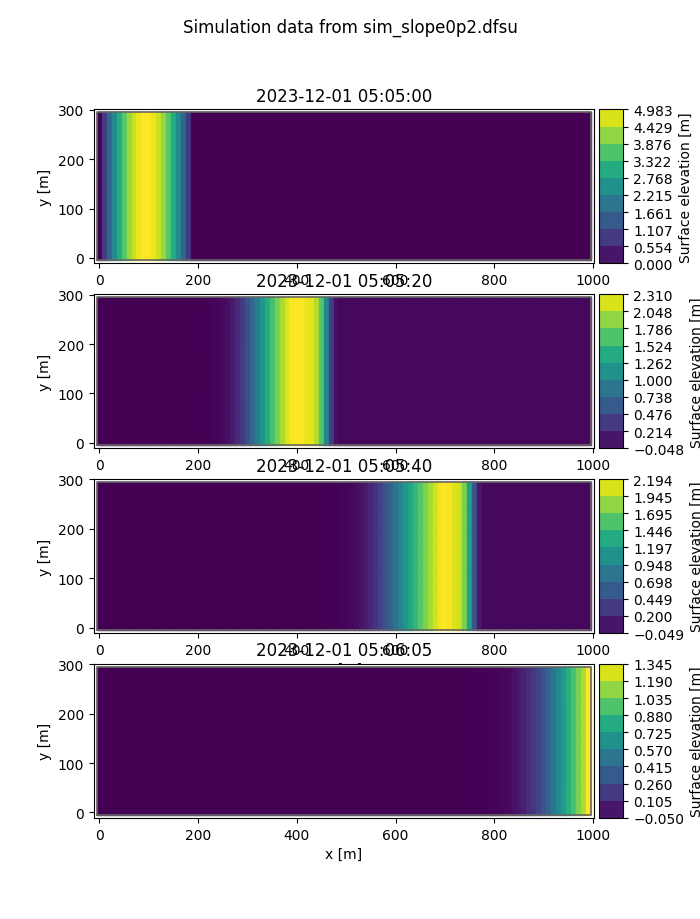

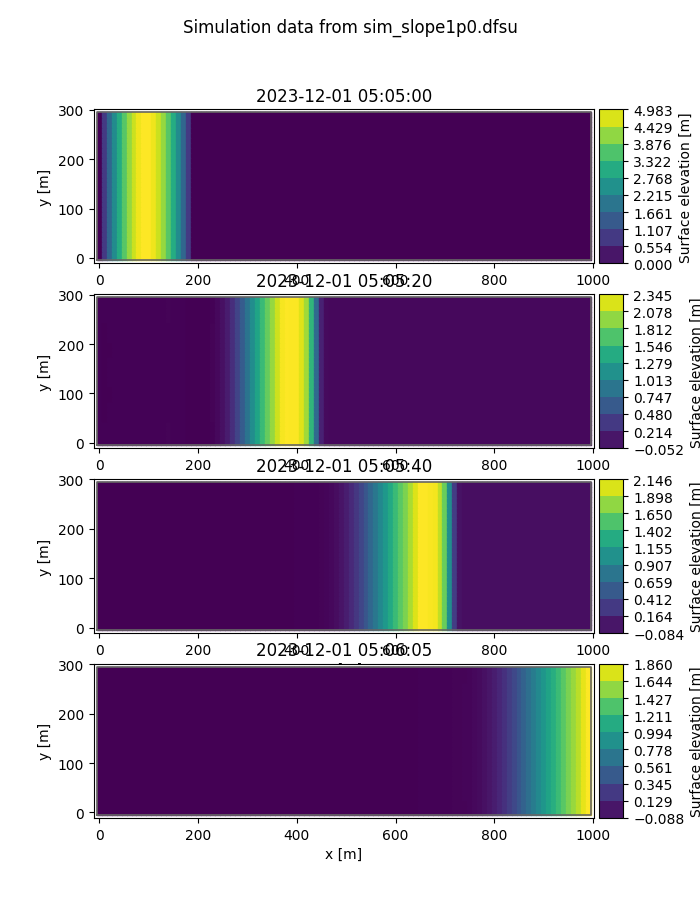

ChatCompletion(id='chatcmpl-9cSW9pBDzYcNKtywYa6onN8F5pOlF', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='### Comparison of Simulation Results:\n\n#### First Simulation (sim_slope0p2.dfsu):\n1. **Timestamp: 2023-12-01 05:05:00**\n   - Surface elevation ranges from 0 to 4.983 meters.\n   - Notable wavefront present at approximately x=100m, with the area of maximum elevation indicated in yellow.\n\n2. **Timestamp: 2023-12-01 05:05:20**\n   - Elevation ranges from 0 to 2.310 meters.\n   - Wave has propagated, with the peak now around x=200m to x=300m, indicating movement and dispersion.\n\n3. **Timestamp: 2023-12-01 05:05:40**\n   - Elevation ranges from 0 to 2.194 meters.\n   - The wave continues to move to the right, now concentrated around x=500m to x=700m.\n\n4. **Timestamp: 2023-12-01 05:06:05**\n   - Elevation ranges from 0 to 1.345 meters.\n   - The wave has significantly dissipated, with highest elevation shifting further to t

In [2]:
import importlib
import evaluation_tools

# Reload the module to reflect any updates
importlib.reload(evaluation_tools)

# Example usage
image_files = ["sim_slope0p2.png", "sim_slope1p0.png"]  # list of image file names
added_context = "Simulation 1 yields a slope of 0.2 degrees, while simulation 2 yields a slope of 1.0 degrees in bathymetry. Both increasing from left to right."

response = evaluation_tools.analyze_images(image_files, added_context)
response


In [3]:
from IPython.display import display, Markdown
display(Markdown(response.choices[0].message.content))

### Comparison of Simulation Results:

#### First Simulation (sim_slope0p2.dfsu):
1. **Timestamp: 2023-12-01 05:05:00**
   - Surface elevation ranges from 0 to 4.983 meters.
   - Notable wavefront present at approximately x=100m, with the area of maximum elevation indicated in yellow.

2. **Timestamp: 2023-12-01 05:05:20**
   - Elevation ranges from 0 to 2.310 meters.
   - Wave has propagated, with the peak now around x=200m to x=300m, indicating movement and dispersion.

3. **Timestamp: 2023-12-01 05:05:40**
   - Elevation ranges from 0 to 2.194 meters.
   - The wave continues to move to the right, now concentrated around x=500m to x=700m.

4. **Timestamp: 2023-12-01 05:06:05**
   - Elevation ranges from 0 to 1.345 meters.
   - The wave has significantly dissipated, with highest elevation shifting further to the right.

#### Second Simulation (sim_slope1p0.dfsu):
1. **Timestamp: 2023-12-01 05:05:00**
   - Surface elevation ranges from 0 to 4.983 meters.
   - Initial wavefront present at approximately x=100m, identical to first simulation.

2. **Timestamp: 2023-12-01 05:05:20**
   - Elevation ranges from 0 to 2.345 meters.
   - Wave propagation similar to first simulation, with shifting towards x=200m to x=300m.

3. **Timestamp: 2023-12-01 05:05:40**
   - Elevation ranges from 0 to 2.146 meters.
   - Further movement and dispersion to the right, concentrated around x=500m to x=700m.

4. **Timestamp: 2023-12-01 05:06:05**
   - Elevation ranges from 0 to 1.860 meters.
   - The significant difference in dissipation and displacement in amplitude compared to the first simulation. The wave is more pronounced and has not dissipated as much as in the first simulation.

### Key Differences:
- **Dissipation Rate**: The wave from the second simulation (sim_slope1p0.dfsu) exhibits less dissipation over time compared to the first simulation (sim_slope0p2.dfsu), where the maximum elevation significantly lowers from higher initial values.
- **Propagation**: Both simulations show similar wavefront movements, but the second simulation maintains a higher surface elevation throughout the timestamps analyzed.

### Conclusion:
The second set of simulations suggests a reduced slope environment (slope1p0) results in less dissipation of the wave energy over time compared to the first set (slope0p2). The wave in the second simulation maintains higher elevations over a longer distance.

## evaluate point

* extract timeseries
* forecast with nixtla gpt

# Future

* multi-step iterations, e.g. create domain of x,y, add initial condition, run a simulation and evaluate all in one go
* try assistants https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant